# Adaptive PDE discretizations on cartesian grids 
## Volume : GPU accelerated methods
## Part : Reproducibility
## Chapter : Flow and geodesics

We compute the geodesic flow and minimal geodesics, on the CPU and GPU, checking for consistency.

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"../..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Isotropic_Repro','GPU'))

In [2]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [62]:
from agd import HFMUtils
from agd import AutomaticDifferentiation as ad
from agd import Metrics
from agd import FiniteDifferences as fd
from agd import LinearParallel as lp
import agd.AutomaticDifferentiation.cupy_generic as cugen
norm_infinity = ad.Optimization.norm_infinity
from agd.HFMUtils import RunGPU,RunSmart

In [4]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global HFMUtils,ad,cugen,RunGPU
    HFMUtils,ad,cugen,RunGPU = rreload([HFMUtils,ad,cugen,RunGPU],"../..")    

In [5]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)
RunSmart = cugen.cupy_get_args(RunSmart,dtype64=True,iterables=(dict,Metrics.Base))

In [6]:
def RunCompare(gpuIn,check=True):
    gpuOut = RunGPU(gpuIn)
    if gpuIn.get('verbosity',1): print("---")
    cpuOut = RunSmart(gpuIn)
    print("Max |gpuValues-cpuValues| : ", norm_infinity(gpuOut['values'].get()-cpuOut['values']))
    cpuTime = cpuOut['FMCPUTime']; gpuTime = gpuOut['solverGPUTime'];
    print(f"Solver time (s). GPU : {gpuTime}, CPU : {cpuTime}. Device acceleration : {cpuTime/gpuTime}")
    assert not check or cp.allclose(gpuOut['values'],cpuOut['values'],atol=1e-6)
    return gpuOut,cpuOut

## 1. Constant metrics

When the metric is constant, the geodesic flow is directed toward the seed point, and the geodesic are straight lines.

### 1.1 Isotropic metrics

In [7]:
n=201
hfmIn = HFMUtils.dictIn({
    'model':'Isotropic2',
    'seeds':[[0.,0.]],
    'exportValues':1,
    'cost':cp.array(1.),
    'exportGeodesicFlow':1,
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
X = hfmIn.Grid()
hfmIn['tips']=hfmIn.Grid(dims=(4,4)).reshape(2,-1).T

Casting output of function array from float64 to float32


In [15]:
gpuOut = RunGPU(hfmIn)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.005975008010864258 seconds,  and 10 iterations.
Post-Processing


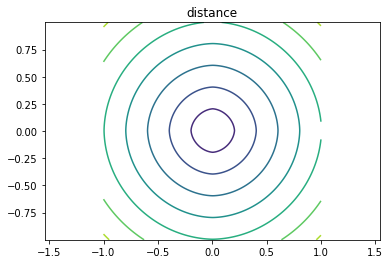

In [9]:
plt.title('distance'); plt.axis('equal')
plt.contour(*X,gpuOut['values']);

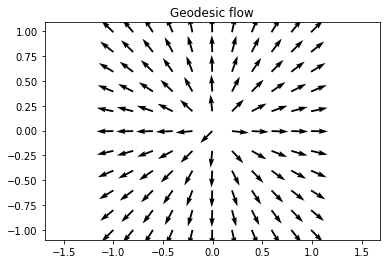

In [10]:
plt.title("Geodesic flow"); plt.axis('equal')
s=20; plt.quiver(*X[:,::s,::s],*gpuOut['flow'][:,::s,::s]);

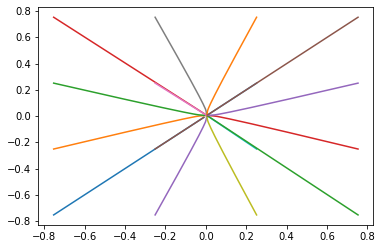

In [11]:
for geo in gpuOut['geodesics']: plt.plot(*geo);

### 1.2 Riemannian metrics

In [16]:
n=199
hfmIn = HFMUtils.dictIn({
    'model':'Riemann2',
    'seeds':[[0.,0.]],
    'exportValues':1,
    'metric':Metrics.Riemann(cp.array([[1.,1.],[1.,2.]])),
    'exportGeodesicFlow':1,
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
X = hfmIn.Grid()
hfmIn['tips']=hfmIn.Grid(dims=(4,4)).reshape(2,-1).T

Casting output of function array from float64 to float32


In [17]:
gpuOut = RunGPU(hfmIn)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.034972429275512695 seconds,  and 66 iterations.
Post-Processing


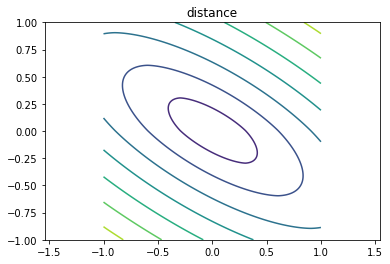

In [18]:
plt.title('distance'); plt.axis('equal')
plt.contour(*X,gpuOut['values']);

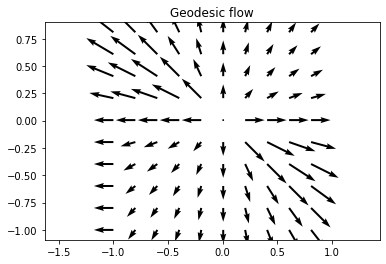

In [19]:
plt.title("Geodesic flow"); plt.axis('equal')
s=20; plt.quiver(*X[:,::s,::s],*gpuOut['flow'][:,::s,::s]);

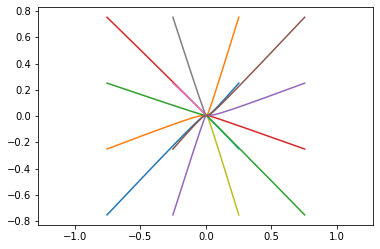

In [20]:
plt.axis('equal')
for geo in gpuOut['geodesics']: plt.plot(*geo);

### 1.3 Rander metrics

In [21]:
n=201
hfmIn = HFMUtils.dictIn({
    'model':'Rander2', 'metric':Metrics.Rander(cp.eye(2),cp.array([0.,0.5])),
    'seeds':[[0.,0.]],
    'exportValues':1,
    'exportGeodesicFlow':1,
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
X = hfmIn.Grid()
hfmIn['tips']=hfmIn.Grid(dims=(4,4)).reshape(2,-1).T

Casting output of function eye from float64 to float32
Casting output of function array from float64 to float32


In [22]:
gpuOut = RunGPU(hfmIn)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.01499795913696289 seconds,  and 28 iterations.
Post-Processing


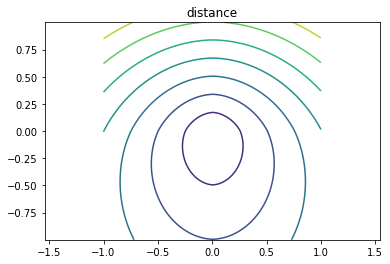

In [23]:
plt.title('distance'); plt.axis('equal')
plt.contour(*X,gpuOut['values']);

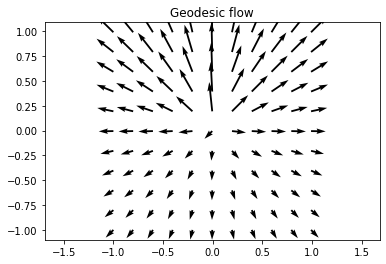

In [24]:
plt.title("Geodesic flow"); plt.axis('equal')
s=20; plt.quiver(*X[:,::s,::s],*gpuOut['flow'][:,::s,::s]);

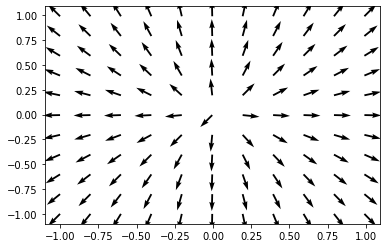

In [25]:
flow=gpuOut['flow'].copy(); flow/=ad.Optimization.norm(flow,axis=0) 
s=20; plt.quiver(*X[:,::s,::s],*flow[:,::s,::s]);

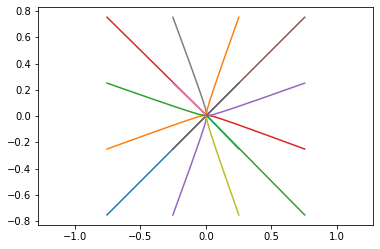

In [26]:
plt.axis('equal')
for geo in gpuOut['geodesics']: plt.plot(*geo);

## 2. Variable metrics

### 2.1 Isotropic

In [104]:
n=200; 
hfmIn.update({
    'model':'Isotropic2',
    'seeds':[[0.,0.]],
    'verbosity':0,
    'exportGeodesicFlow':1,
    'geodesic_hlen':20,
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
X = hfmIn.Grid()
hfmIn.update({
    'cost':np.prod(np.sin(2*np.pi*X),axis=0) +1.1, # Non-constant cost
    'tips':hfmIn.Grid(dims=(5,4)).reshape(2,-1).T
})

In [95]:
gpuOut = RunGPU(hfmIn)

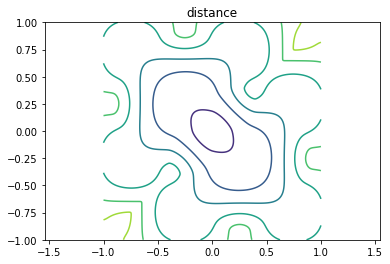

In [96]:
plt.title('distance'); plt.axis('equal')
plt.contour(*X,gpuOut['values']);

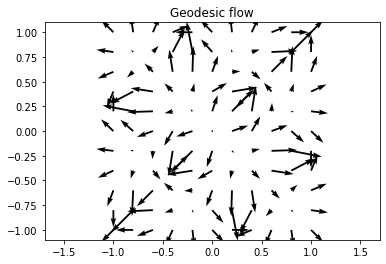

In [103]:
plt.title("Geodesic flow"); plt.axis('equal')
s=20; plt.quiver(*X[:,::s,::s],*gpuOut['flow'][:,::s,::s]);

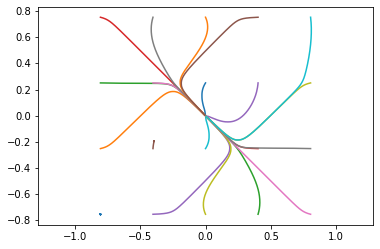

In [97]:
plt.axis('equal')
for geo in gpuOut['geodesics']: plt.plot(*geo);

In [108]:
hfmIn['tips'][0]

array([-0.804, -0.754], dtype=float32)

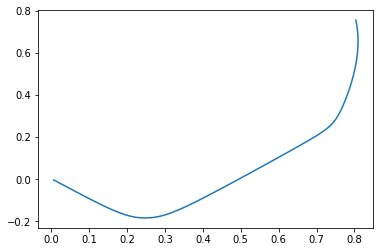

In [110]:
plt.plot(*gpuOut['geodesics'][-1])

In [98]:
gpuOut['geodesic_stopping_criteria']

['Stationnary',
 'AtSeed',
 'AtSeed',
 'AtSeed',
 'AtSeed',
 'Stationnary',
 'AtSeed',
 'AtSeed',
 'AtSeed',
 'AtSeed',
 'AtSeed',
 'AtSeed',
 'AtSeed',
 'AtSeed',
 'AtSeed',
 'AtSeed',
 'AtSeed',
 'AtSeed',
 'AtSeed',
 'AtSeed']

### 2.2 Riemannian

In [63]:
hfmIn = HFMUtils.dictIn({
    'model':'Riemann2',
    'seeds':cp.array([[0.,0.]]),
    'exportValues':1,
    'traits':{
        'niter_i':16,'shape_i':(8,8), # Best
    },
})
hfmIn.SetRect([[-np.pi,np.pi],[-np.pi,np.pi]],dimx=n+1,sampleBoundary=True)
X = hfmIn.Grid()

def height(x): return np.sin(x[0])*np.sin(x[1])
def surface_metric(x,z,mu=10.):
    ndim,shape = x.ndim-1,x.shape[1:]
    x_ad = ad.Dense.identity(constant=x,shape_free=(ndim,))
    tensors = lp.outer_self( z(x_ad).gradient() ) + mu**-2 * fd.as_field(cp.eye(ndim),shape)
    return Metrics.Riemann(tensors)

hfmIn['metric'] = surface_metric(X,height)
hfmIn['tips']=hfmIn.Grid(dims=(5,4)).reshape(2,-1).T

Casting output of function array from float64 to float32
Casting output of function eye from float64 to float32


In [64]:
gpuOut = RunGPU(hfmIn)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.02399754524230957 seconds,  and 54 iterations.
Post-Processing


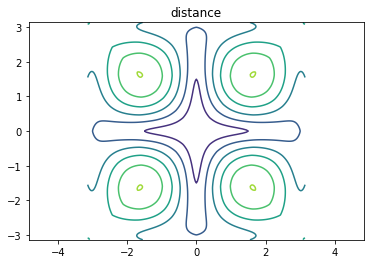

In [65]:
plt.title('distance'); plt.axis('equal')
plt.contour(*X,gpuOut['values']);

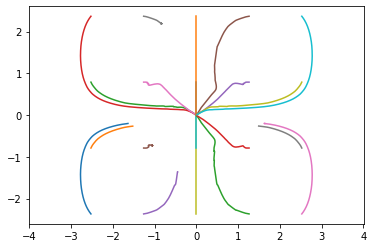

In [66]:
plt.axis('equal')
for geo in gpuOut['geodesics']: plt.plot(*geo);

### 2.3 Rander

In [67]:
hfmIn = HFMUtils.dictIn({
    'model':'Rander2',
    'seeds':cp.array([[0.,0.]]),
    'exportValues':1,
})
hfmIn.SetRect([[-2.*np.pi,2.*np.pi],[-2.*np.pi,2.*np.pi]],dimx=n+1)
X = hfmIn.Grid()

def Drift(x):
    mult = 0.9*np.sin(x[0])*np.sin(x[1]) / np.linalg.norm(x,axis=0)
    mult[np.isnan(mult)]=0.
    return mult*x

hfmIn['metric']=Metrics.Rander.from_Zermelo(cp.eye(2),Drift(X))
hfmIn['tips']=hfmIn.Grid(dims=(5,4)).reshape(2,-1).T

Casting output of function array from float64 to float32
Casting output of function eye from float64 to float32


In [68]:
gpuOut = RunGPU(hfmIn)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.01699542999267578 seconds,  and 37 iterations.
Post-Processing


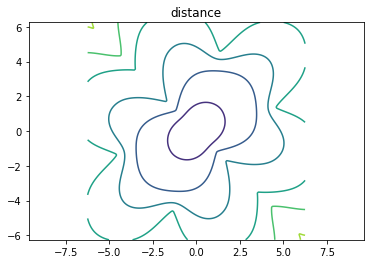

In [69]:
plt.title('distance'); plt.axis('equal')
plt.contour(*X,gpuOut['values']);

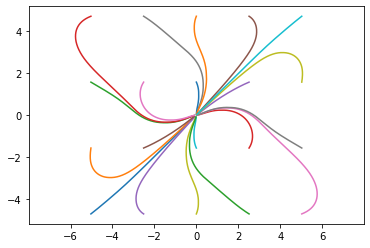

In [70]:
plt.axis('equal')
for geo in gpuOut['geodesics']: plt.plot(*geo);